In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/PG1522+101/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.22541394/cloudy_fits/'

Obtain the UVB grid from FG20

In [5]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [6]:
z_test = 1

In [7]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [8]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [9]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [10]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [11]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [12]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [13]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Column density ratios

In [14]:
logN_dict = {'HI':'14.00, -0.06, +0.08',
            'HeI':'<13.7',
            'CII':'<13.7',
            'CIII':'<12.9',
            'CIV':'12.70, -0.06, +0.06',
            'NII':'<13.4',
            'NIII':'<13.1',
            'NIV':'<13.6',
            'NV':'<13.4',
            'OII':'<13.9',
            'OIII':'<13.4',
            'OIV':'13.85, -0.04, +0.04',
            'OV':'14.3, -0.1, +0.1',
            'OVI':'14.12, -0.07, +0.07',
            'NeV':'<13.7',
            'NeVI':'<14.0',
            'NeVIII':'<13.9',
            'MgII':'<15.4',
            'MgX':'<13.5',
            'AlII':'<11.2',
            'AlIII':'<11.6',
            'SiII':'<14.3',
            'SiIII':'<12.1',
            'SiIV':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.5',
            'FeII':'<11.8',}

In [15]:
gen_logN_ratio_str(logN_dict['CIV'], logN_dict['OIV'])

'-1.15, -0.07, 0.07'

In [16]:
logN_ratio_dict = {'HeI/HI': '<-1.00, 0.16',
                   'CIV/CIII': '>-0.21, 0.15',
                   'OIII/OIV': '<-0.45, 0.15',
                    'OV/OIV': '0.45, -0.11, 0.11',
                   'OVI/OV': '-0.18, -0.12, 0.12'}

(-2.2, 2.5)

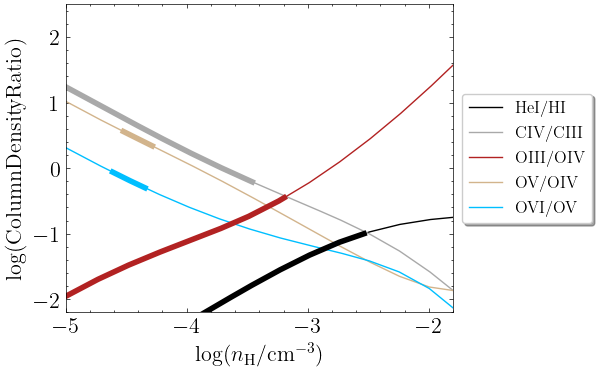

In [17]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.8)
ax.set_ylim(-2.2, 2.5)

In [18]:
logN_ratio_dict = {'OVI/OV': '-0.18, -0.12, 0.12',
                    'OV/OIV': '0.45, -0.11, 0.11'
                   }

Text(0, 0.5, 'log(Column density ratio)')

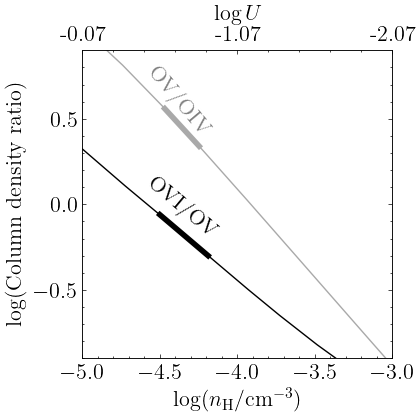

In [19]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.0)

ax.text(-4.6, -0.2, 'OVI/OV', rotation=-40)
ax.text(-4.6, 0.4, 'OV/OIV', rotation=-50, color='gray')

ax_copy = ax.twiny()
ax_copy.set_xticks([-5, -4, -3, -2],[-0.07,-1.07,-2.07,-3.07])


ax.set_xlim(-5, -3)
ax_copy.set_xlim(-5, -3)

ax.set_ylim(-.9, .9)

ax_copy.set_xlabel(r'$\log U$')
ax.set_ylabel(r'log(Column density ratio)')

In [20]:
logN_ratio_dict = {#'OVI/OV': '-0.18, -0.12, 0.12',
                   # 'OV/OIV': '0.45, -0.11, 0.11',
                   'CIV/OIV': '-1.16, -0.07, 0.07'
                   }

Text(0, 0.5, '$\\log(N_\\mathrm{CIV}/N_\\mathrm{OIV})$')

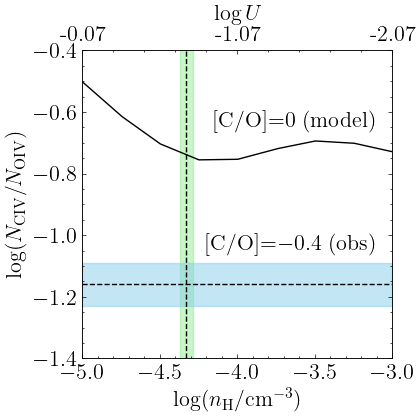

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-1.0)

ax.text(-4.15, -0.65, r'[C/O]=0 (model)')
ax.axvline(-4.33, color='black', linestyle='--')
ax.axvspan(-4.33-0.04,-4.33+0.04, color='lightgreen', alpha=.5)

ax.axhline(-1.16, color='black', linestyle='--')
ax.text(-4.2, -1.05, r'[C/O]=$-$0.4 (obs)')

ax.axhspan(-1.16-0.07,-1.16+0.07, color='skyblue', alpha=.5)

ax_copy = ax.twiny()
ax_copy.set_xticks([-5, -4, -3, -2],[-0.07,-1.07,-2.07,-3.07])


ax.set_xlim(-5, -3)
ax_copy.set_xlim(-5, -3)

ax.set_ylim(-1.4, -.4)

ax_copy.set_xlabel(r'$\log U$')
ax.set_ylabel(r'$\log(N_\mathrm{CIV}/N_\mathrm{OIV})$')

In [22]:
log_metals_arr = np.arange(-1.5, -0.3, 0.1)
logN_OIV_arr = np.array([species_logN_interp['O+3']((14.0, -4.33, m)) for m in log_metals_arr])

Text(-1.45, 14.0, '$\\log(n_\\mathrm{H}/\\mathrm{cm}^{-3}) = -4.3$')

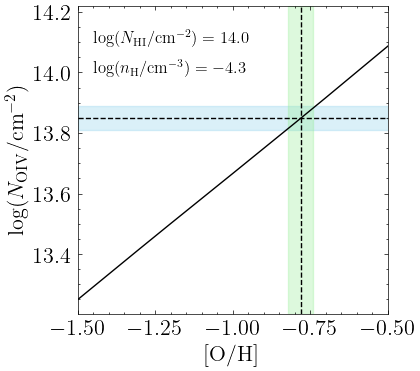

In [23]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_metals_arr, logN_OIV_arr)

ax.axhline(13.85, linestyle='--', color='black')
ax.axhspan(13.85-0.04, 13.85+0.04, color='skyblue', alpha=.3)

ax.axvline(-0.78, linestyle='--')
ax.axvspan(-0.78-0.04, -0.78+0.04, color='lightgreen', alpha=.3)

ax.set_xlim(-1.5, -.5)
ax.set_xlabel(r'[O/H]')
ax.set_ylabel(r'$\log(N_\mathrm{OIV}/\mathrm{cm}^{-2})$')

ax.text(-1.45, 14.1, r'$\log(N_\mathrm{HI}/\mathrm{cm}^{-2}) = 14.0$', fontsize=12)
ax.text(-1.45, 14.0, r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) = -4.3$', fontsize=12)

# Single phase solution

In [24]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [25]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [26]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [27]:
logN_dict = {#'HI':'14.00, -0.06, +0.08',
            'HeI':'<13.7',
            'CII':'<13.7',
            'CIII':'<12.9',
            'CIV':'12.70, -0.06, +0.06',
            'NII':'<13.4',
            'NIII':'<13.1',
            'NIV':'<13.6',
            'NV':'<13.4',
            'OII':'<13.9',
            'OIII':'<13.4',
            'OIV':'13.85, -0.04, +0.04',
            'OV':'14.3, -0.1, +0.1',
            'OVI':'14.12, -0.07, +0.07',
            'NeV':'<13.7',
            'NeVI':'<14.0',
            #'NeVIII':'<13.9',
            #'MgII':'<15.4',
            #'MgX':'<13.5',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            'SiII':'<14.3',
            'SiIII':'<12.1',
            'SiIV':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [28]:
logN_HI_test = 14.0
log_hdens_test = -4.3
log_metals_test = -0.7
C_O_test = -0.6
N_O_test = -1.0

In [29]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [30]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

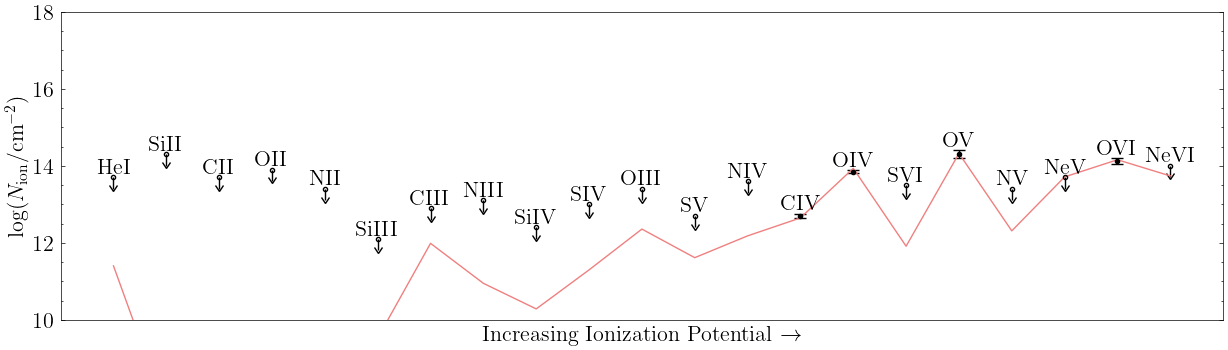

In [31]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [32]:
pos = np.array([log_hdens_test, log_metals_test, C_O_test, N_O_test]) + 1e-7 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape

In [33]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [34]:
#sampler.run_mcmc(pos, 500, progress=True);

In [35]:
#flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens', 'log_metals', 'C_O', 'N_O'])
#flat_samples.to_csv(savedir+'one_phase.csv', index=False)

flat_samples = pd.read_csv(savedir+'one_phase.csv')

In [36]:
#flat_samples

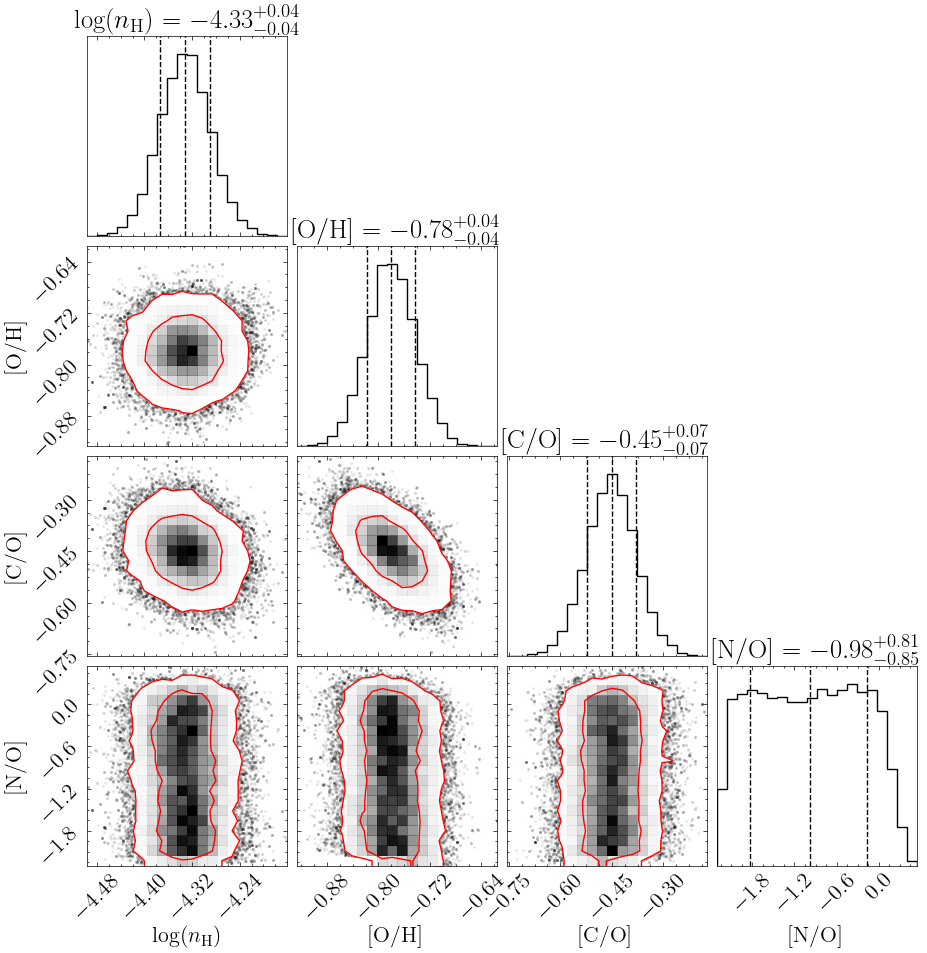

In [37]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$', r'$[\mathrm{C/O}]$', r'$[\mathrm{N/O}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [38]:
np.median(flat_samples['C_O'])

-0.4508296369739978

In [39]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.42346736870713525

Now plot the best models

In [40]:
logN_dict = {#'HI':'14.00, -0.06, +0.08',
            #'HeI':'<13.7',
            #'CII':'<13.7',
            #'CIII':'<12.9',
            'CIV':'12.70, -0.06, +0.06',
            #'NII':'<13.4',
            #'NIII':'<13.1',
            'NIV':'<13.6',
            #'NV':'<13.4',
            #'OII':'<13.9',
            #'OIII':'<13.4',
            'OIV':'13.85, -0.04, +0.04',
            'OV':'14.3, -0.1, +0.1',
            'OVI':'14.12, -0.07, +0.07',
            'NeV':'<13.7',
            'NeVI':'<14.0',
            #'NeVIII':'<13.9',
            #'MgII':'<15.4',
            #'MgX':'<13.5',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            #'SiII':'<14.3',
            #'SiIII':'<12.1',
            #'SiIV':'<12.4',
            #'SIV':'<13.0',
            'SV':'<12.7',}
            #'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [41]:
b_dict = {'HI':'25, -4, +4',
          'CIV':'16, -3, +3',
          'OIV':'21, -2, +2',
          'OV':'21, -2, +2',
          'OVI':'21, -2, +2'}

In [42]:
z_sys = 1.22541394

In [43]:
import matplotlib.lines as mlines

In [44]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [45]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [46]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['SV'] = '<0.36'
logN_res_up['NIV'] = '<0.36'

In [47]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [48]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

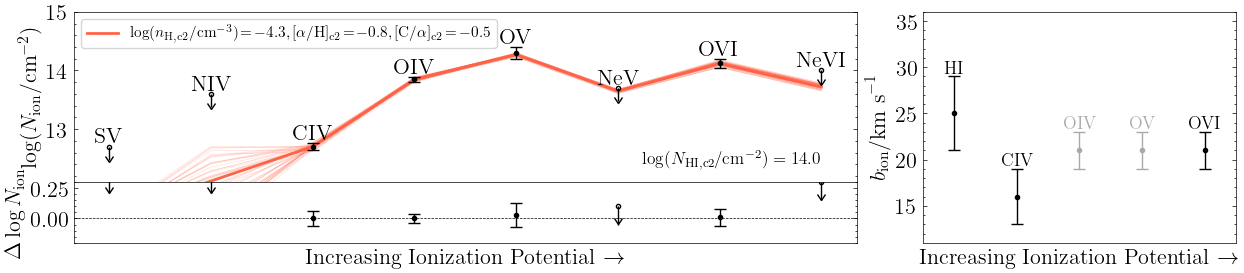

In [49]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.15)

axd['upper left'].set_ylim(12.1,15.0)

axd['upper left'].text(len(logN_dict)-1, 12.4, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.0$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c2}/\mathrm{cm}^{-3}) \!=\! -4.3, \mathrm{[\alpha/H]_{c2}} \!=\! -0.8, \mathrm{[C/\alpha]_{c2}}\!=\!-0.5$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=11)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-.2,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['OIV', 'OV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(11,36)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

## Presentation plot

In [50]:
logN_dict = {#'HI':'14.00, -0.06, +0.08',
            #'HeI':'<13.7',
            #'CII':'<13.7',
            #'CIII':'<12.9',
            'CIV':'12.70, -0.06, +0.06',
            #'NII':'<13.4',
            #'NIII':'<13.1',
            #'NIV':'<13.6',
            #'NV':'<13.4',
            #'OII':'<13.9',
            'OIII':'<13.4',
            'OIV':'13.85, -0.04, +0.04',
            'OV':'14.3, -0.1, +0.1',
            'OVI':'14.12, -0.07, +0.07',
            'NeV':'<13.7',
            'NeVI':'<14.0',}
            #'NeVIII':'<13.9',
            #'MgII':'<15.4',
            #'MgX':'<13.5',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            #'SiII':'<14.3',
            #'SiIII':'<12.1',
            #'SiIV':'<12.4',
            #'SIV':'<13.0',
            #'SV':'<12.7',}
            #'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [51]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [52]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [53]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

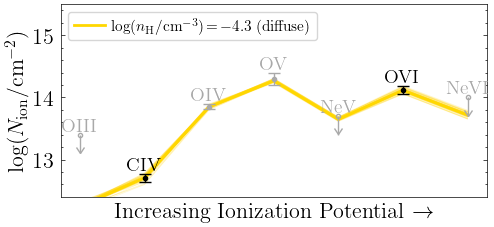

In [54]:
fig, ax = plt.subplots(1, figsize=(5.5,2.5))

for idx in plot_idx:
    ax.plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    
ax.plot(np.arange(len(logN_dict)), logN_species_best, color='gold', lw=2)
   
plot_column_densities_obs(logN_dict, fig, ax, c_dy=1.5, gray_out=['OIII', 'OIV', 'OV', 'NeV', 'NeVI'], fs=14)

#ax.text(-0.2, 12.4, r'$\log(N_\mathrm{HI, c1}/\mathrm{cm}^{-2}) = 14.9$', fontsize=12.5,
#            horizontalalignment='left')

ax.set_ylim(12.4,15.5)

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H}/\mathrm{cm}^{-3}) \!=\! -4.3$ (diffuse)'))

#handles.append(mlines.Line2D([], [], lw=2,
#                             color='gold', 
#                             marker='None',
#              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c1L}/\mathrm{cm}^{-3}) \!=\! -4.2$ (diffuse)'))
     
ax.legend(handles=handles, loc='upper left', fontsize=11, ncol=2, columnspacing=.6, handletextpad=0.4)

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_no_lw.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_no_lw.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [51]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

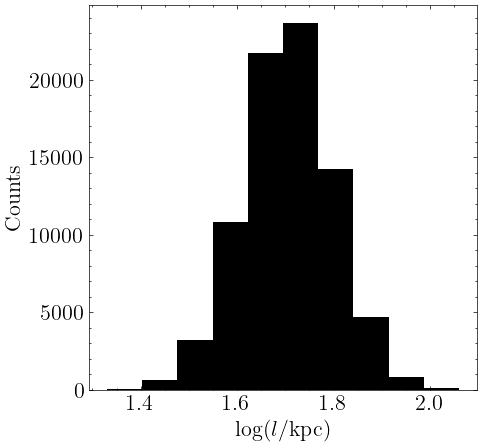

In [52]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [54]:
get_quantiles(np.log10(l))

1.71 -0.09 0.09


# Single phase solution - oxygen only

In [107]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}])
    
    return log_prior(params_full)

In [108]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [109]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [136]:
logN_dict = {#'HI':'14.00, -0.07, +0.07',
                #'HeI':'<13.7',
                #'CII':'<13.7',
                #'CIII':'<12.9',
                #'CIV':'12.69, -0.06, +0.06',
                #'NII':'<13.4',
                #'NIII':'<13.1',
                #'NIV':'<13.6',
                #'NV':'<13.4',
                #'OII':'<13.9',
                #'OIII':'<13.4',
                'OIV':'13.85, -0.04, +0.04',
                'OV':'14.3, -0.1, +0.1',}
                #'OVI':'14.12, -0.07, +0.07',}
                #'NeV':'<13.7',
                #'NeVI':'<14.0',
                #'NeVIII':'<13.9',
                #'MgII':'<15.4',
                #'MgX':'<13.5',
                #'AlII':'<11.2',
                #'AlIII':'<11.6',
                #'SiII':'<14.3',
                #'SiIII':'<12.1',
                #'SiIV':'<12.4',
                #'SIV':'<13.0',
                #'SV':'<12.7',
                #'SVI':'<13.5',}
                #'FeII':'<11.8',}

In [137]:
logN_HI_test = 14.0
log_hdens_test = -4.3
log_metals_test = -0.7
C_O_test = -0.6
N_O_test = -1.0

In [138]:
#species_logN_interp['Si+2']([logN_HI_test, log_hdens_test_p1, log_metals_test_p1])[0]

In [139]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

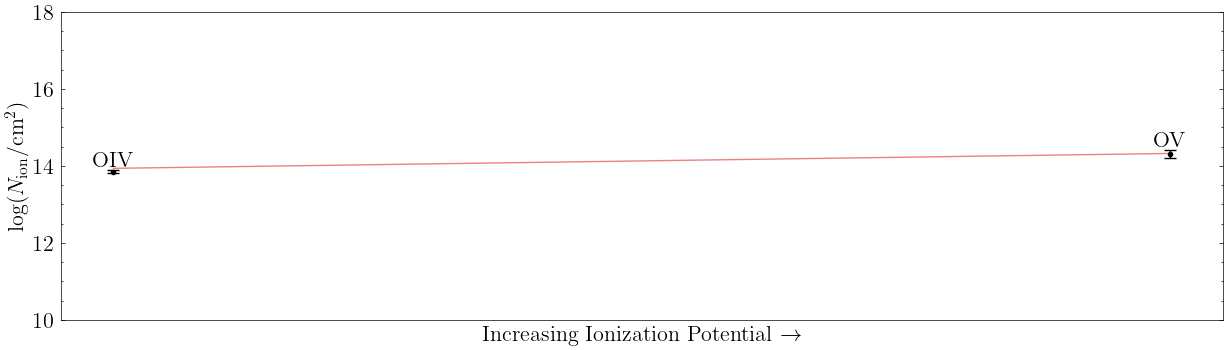

In [140]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [141]:
pos = np.array([log_hdens_test, log_metals_test]) + 1e-7 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [142]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [143]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [00:17<00:00, 28.42it/s]


In [144]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals'])
flat_samples.to_csv(savedir+'one_phase_oxy.csv', index=False)

#flat_samples = pd.read_csv(savedir+'one_phase_oxy.csv')

In [145]:
#flat_samples

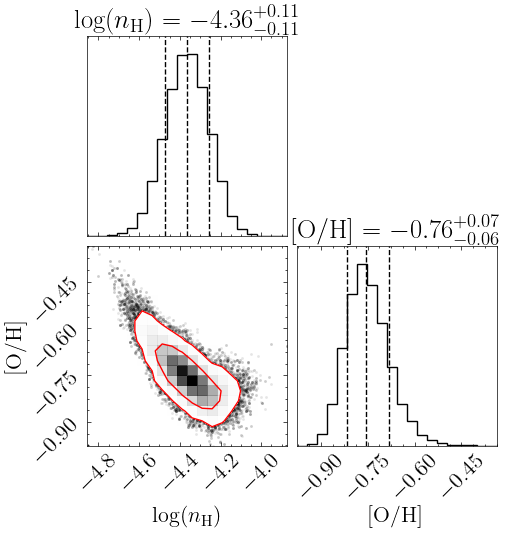

In [146]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{O/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [32]:
np.percentile(flat_samples['N_O'], 100*cdf_3sig)

0.4135998715112652

Now plot the best models

In [33]:
logN_dict = {#'HI':'14.00, -0.07, +0.07',
            #'HeI':'<13.7',
            #'CII':'<13.7',
            #'CIII':'<12.9',
            'CIV':'12.69, -0.06, +0.06',
            #'NII':'<13.4',
            #'NIII':'<13.1',
            'NIV':'<13.6',
            #'NV':'<13.4',
            #'OII':'<13.9',
            #'OIII':'<13.4',
            'OIV':'13.85, -0.04, +0.04',
            'OV':'14.3, -0.1, +0.1',
            'OVI':'14.12, -0.07, +0.07',
            'NeV':'<13.7',
            'NeVI':'<14.0',
            #'NeVIII':'<13.9',
            #'MgII':'<15.4',
            #'MgX':'<13.5',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            #'SiII':'<14.3',
            #'SiIII':'<12.1',
            #'SiIV':'<12.4',
            #'SIV':'<13.0',
            'SV':'<12.7',}
            #'SVI':'<13.5',}
            #'FeII':'<11.8',}

In [34]:
b_dict = {'HI':'26, -4, +5',
          'CIV':'16, -3, +3',
          'OIV':'21, -2, +2',
          'OV':'21, -2, +2',
          'OVI':'21, -2, +2'}

In [35]:
z_sys = 1.22541394

In [36]:
import matplotlib.lines as mlines

In [37]:
logN_species_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples['log_hdens']), 
                                        np.median(flat_samples['log_metals']), 
                                        species_logN_interp, {'C':np.median(flat_samples['C_O']), 
                                                              'N':np.median(flat_samples['N_O'])})

In [38]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [39]:
logN_res_up = {k:'<0.5' for k in list(logN_res_dict.keys())}

logN_res_up['SV'] = '<0.36'
logN_res_up['NIV'] = '<0.36'

In [40]:
# Model curves for each step
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

In [41]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_lo = np.percentile(flat_samples['log_hdens'], 100*(1-cdf_1sig))
log_hdens_hi = np.percentile(flat_samples['log_hdens'], 100*cdf_1sig)

log_metals_lo = np.percentile(flat_samples['log_metals'], 100*(1-cdf_1sig))
log_metals_hi = np.percentile(flat_samples['log_metals'], 100*cdf_1sig)

C_O_lo = np.percentile(flat_samples['C_O'], 100*(1-cdf_1sig))
C_O_hi = np.percentile(flat_samples['C_O'], 100*cdf_1sig)

N_O_lo = np.percentile(flat_samples['N_O'], 100*(1-cdf_1sig))
N_O_hi = np.percentile(flat_samples['N_O'], 100*cdf_1sig)

for i in range(len(flat_samples)):
    log_hdens = flat_samples['log_hdens'][i]
    log_metals = flat_samples['log_metals'][i]
    C_O = flat_samples['C_O'][i]
    N_O = flat_samples['N_O'][i]
    
    if log_hdens_lo<log_hdens<log_hdens_hi and log_metals_lo<log_metals<log_metals_hi and C_O_lo<C_O<C_O_hi and N_O_lo<N_O<N_O_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

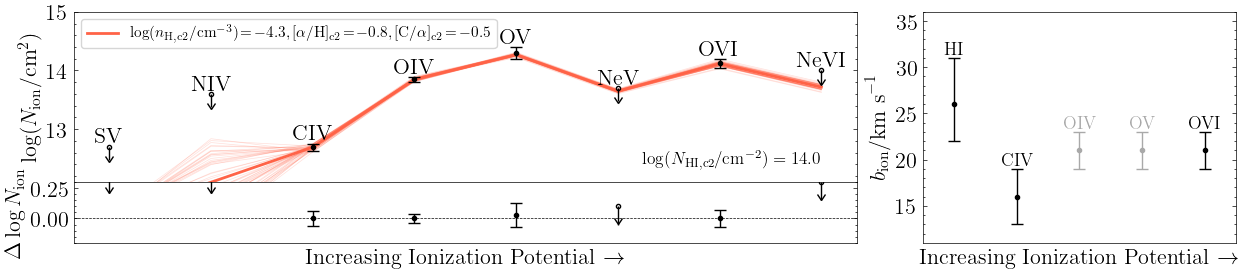

In [48]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.15)

axd['upper left'].set_ylim(12.1,15.0)

axd['upper left'].text(len(logN_dict)-1, 12.4, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.0$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c2}/\mathrm{cm}^{-3}) \!=\! -4.3, \mathrm{[\alpha/H]_{c2}} \!=\! -0.8, \mathrm{[C/\alpha]_{c2}}\!=\!-0.5$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=11)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-.2,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['OIV', 'OV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(11,36)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [46]:
l = get_cloud_size(logN_HI_test, flat_samples['log_hdens'], species_logN_interp, flat_samples['log_metals'])

Text(0, 0.5, 'Counts')

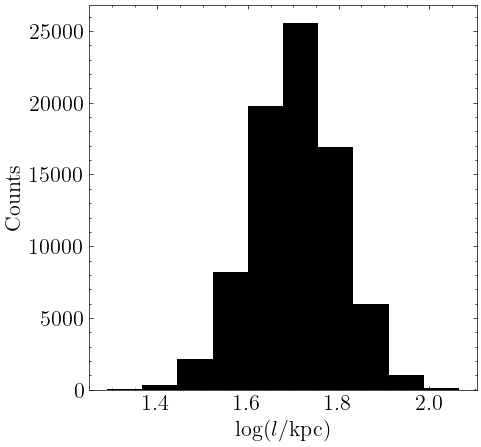

In [47]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l), bins=10)

ax.set_xlabel(r'$\log(l/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [48]:
get_quantiles(np.log10(l))

1.71 -0.1 0.09


# Two-phase solution

In [48]:
def lambda_log_prior_two_phase(params, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

    #x = log_prior_two_phase(params_full, species_logN_interp)
    
    #if np.isfinite(x):
    #    if C_O_p1 < 1.5:
    #        return x
    #    else:
    #        return -np.inf
    #else:
    #    return -np.inf

In [49]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [50]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params, species_logN_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [51]:
logN_dict = {'HI':'14.00, -0.07, +0.07',
        'HeI':'<13.0',
        'CII':'<13.5',
        'CIII':'<12.9',
        'CIV':'12.69, -0.06, +0.06',
        'NII':'<13.4',
        'NIII':'<13.1',
        'NIV':'<12.7',
        'NV':'<13.4',
        'OII':'<13.9',
        'OIII':'<13.4',
        'OIV':'13.85, -0.04, +0.04',
        'OV':'14.3, -0.1, +0.1',
        'OVI':'14.12, -0.07, +0.07',
        'NeV':'<13.4',
        'NeVI':'<13.5',
        #'NeVIII':'<13.5',
        'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.6',
        'SiII':'<14.0',
        'SiIII':'<12.1',
        'SiIV':'<12.4',
        'SIV':'<12.9',
        'SV':'<12.5',
        'SVI':'<13.3',}
        #'FeII':'<11.8',}

In [52]:
logN_HI_test = 14.00
log_hdens_test_p1 = -3.3
log_metals_test_p1 = -1.0
C_O_test_p1 = -1.5
N_O_test_p1 = -1.5

logN_HI_test_p2 = 13.00
log_hdens_test_p2 = -4.4
log_metals_test_p2 = 0.3
C_O_test_p2 = -0.5
N_O_test_p2 = -2.0

In [53]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [54]:
get_cloud_size(logN_HI_test, log_hdens_test_p1, species_logN_interp, log_metals_test_p1)

0.350824362722669

In [55]:
get_cloud_size(logN_HI_test_p2, log_hdens_test_p2, species_logN_interp, log_metals_test_p2)

5.358455405136434

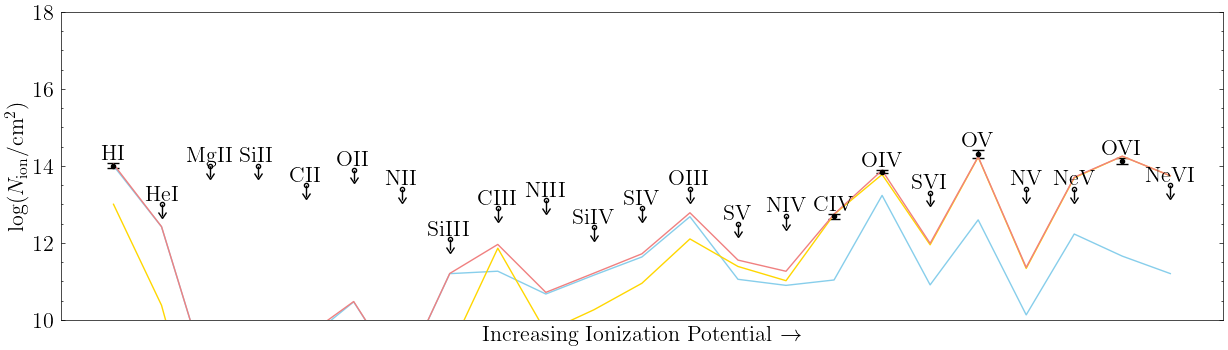

In [56]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [57]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [58]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [59]:
#sampler.run_mcmc(pos, 500, progress=True);

In [60]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase.csv')

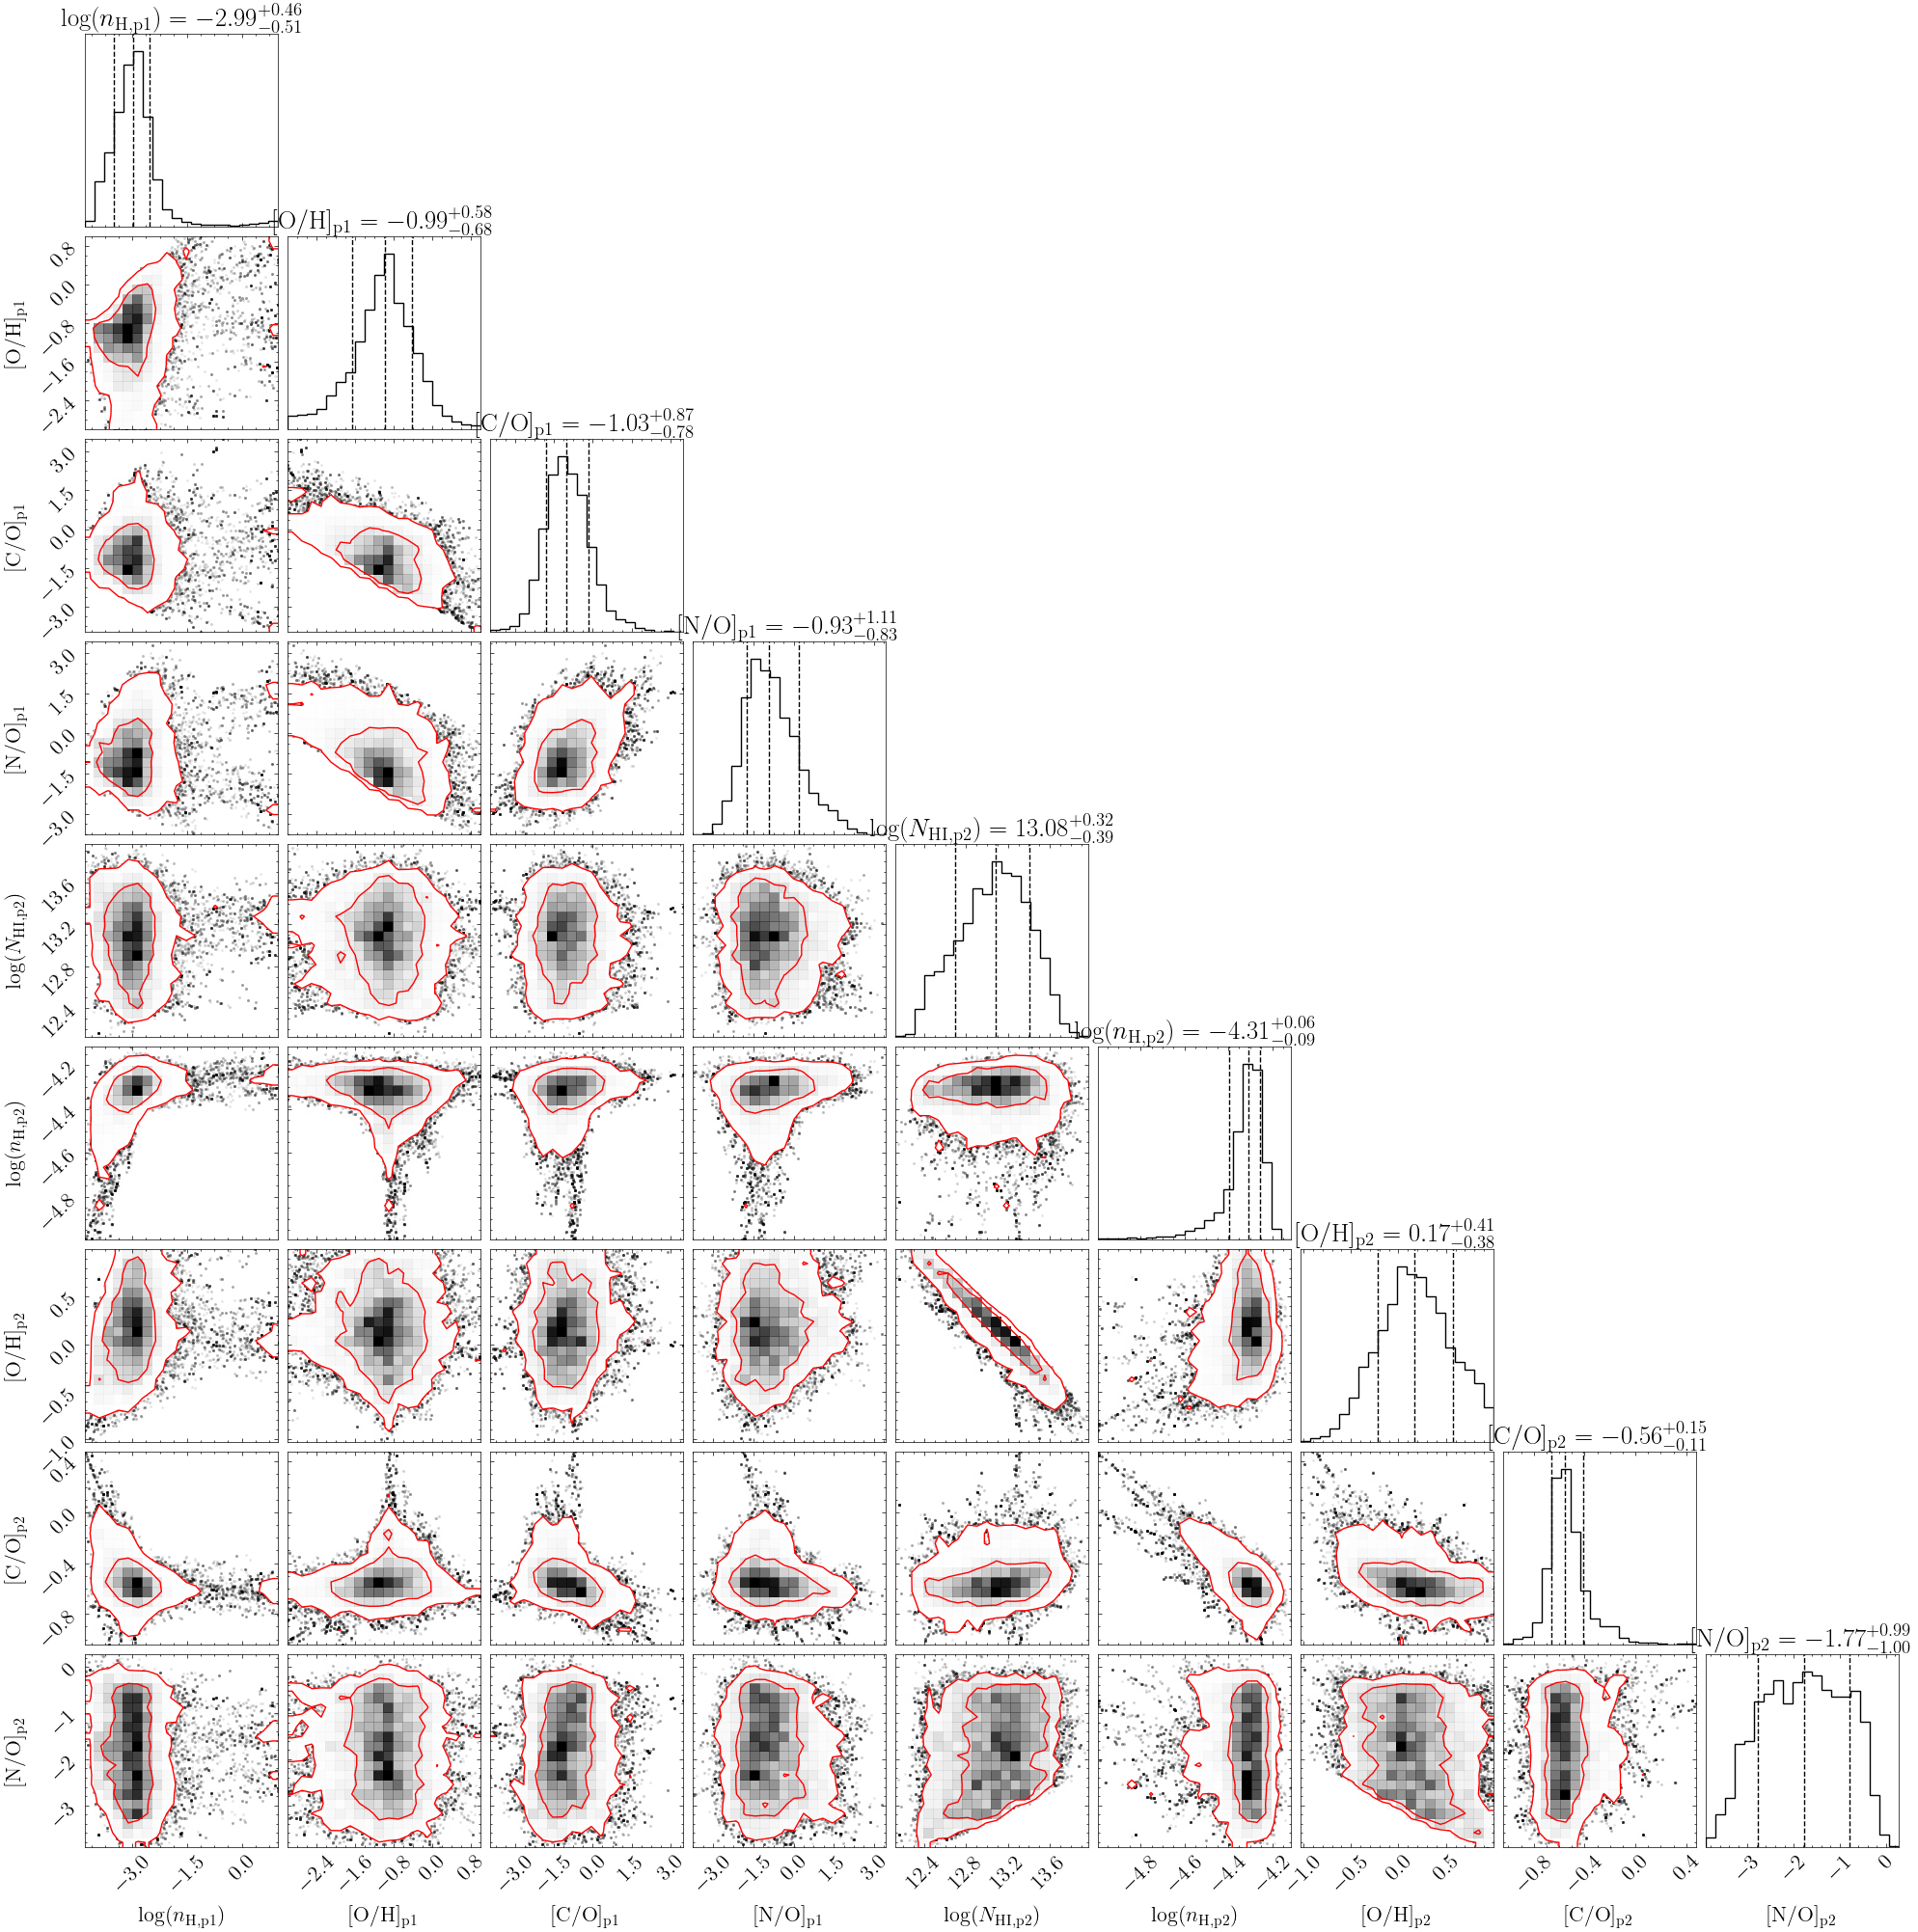

In [61]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [62]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_1sig)-np.median(flat_samples_two_phase['C_O_p2'])

0.14626123185469908

In [63]:
np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_3sig)

(0.9110188583340656, 2.459202008250737, 2.4554725600833307)

In [64]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(12.28048202650466, 13.834004786962344)

In [65]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-0.8570855438650112, 0.9900346815279144)

In [66]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

(0.3435299685584975, -0.008852427907811)

(array([   83.,   295.,  1176.,  2885., 10314., 20900., 26019., 14729.,
         3240.,   359.]),
 array([-4.155481  , -3.39813024, -2.64077948, -1.88342872, -1.12607796,
        -0.3687272 ,  0.38862356,  1.14597432,  1.90332508,  2.66067584,
         3.4180266 ]),
 <BarContainer object of 10 artists>)

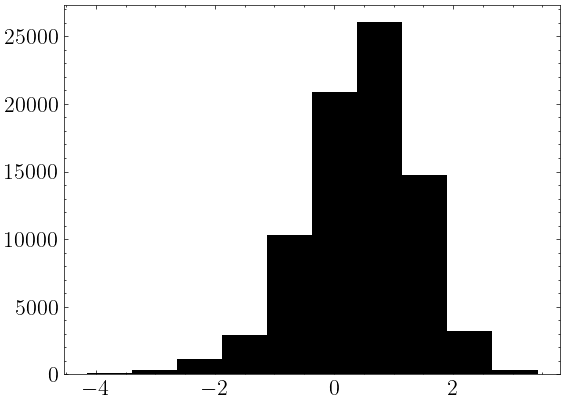

In [67]:
plt.hist(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'])

In [68]:
np.percentile(flat_samples_two_phase['C_O_p2']-flat_samples_two_phase['C_O_p1'], 100*cdf_3sig)

3.119488816463462

Now plot the best models

In [69]:
logN_dict = {#'HI':'14.00, -0.07, +0.07',
        'HeI':'<13.0',
        #'CII':'<13.5',
        'CIII':'<12.9',
        'CIV':'12.69, -0.06, +0.06',
        #'NII':'<13.4',
        #'NIII':'<13.1',
        'NIV':'<12.7',
        #'NV':'<13.4',
        #'OII':'<13.9',
        'OIII':'<13.4',
        'OIV':'13.85, -0.04, +0.04',
        'OV':'14.3, -0.1, +0.1',
        'OVI':'14.12, -0.07, +0.07',
        'NeV':'<13.4',
        'NeVI':'<13.5',}
        #'NeVIII':'<13.5',
        #'MgII':'<14.0',
        #'MgX':'<13.8',
        #'AlII':'<11.2',
        #'AlIII':'<11.6',
        #'SiII':'<14.0',
        #'SiIII':'<12.1',
        #'SiIV':'<12.4',
        #'SIV':'<12.9',
        #'SV':'<12.5',}
        #'SVI':'<13.3',}
        #'FeII':'<11.8',}

In [70]:
b_dict = {'HI':'26, -4, +5',
          'CIV':'16, -3, +3',
          'OIV':'21, -2, +2',
          'OV':'21, -2, +2',
          'OVI':'21, -2, +2'}

In [71]:
z_sys = 1.22541394

In [72]:
import matplotlib.lines as mlines

In [73]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [74]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_med, logN_species_lo, logN_species_hi)

In [79]:
logN_res_up = {k:'<0.6' for k in list(logN_res_dict.keys())}

#logN_res_up['HeI'] = '<0.45'
logN_res_up['OIII'] = '<0.4'
logN_res_up['NIV'] = '<0.4'

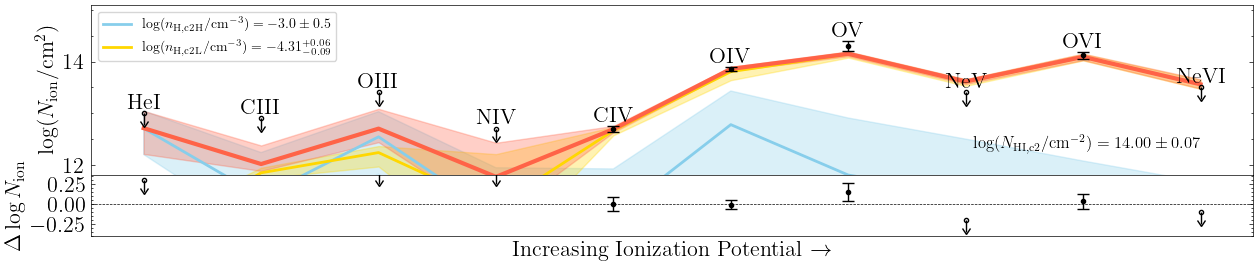

In [80]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axes[0], dy=.15)

axes[0].set_ylim(11.8,15.1)

axes[0].text(len(logN_dict)-1, 12.3, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.00 \pm 0.07$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) = -3.0 \pm 0.5$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) = -4.31_{-0.09}^{+0.06}$'))

axes[0].legend(handles=handles, loc='upper left', fontsize=10)

plot_column_densities_obs(logN_res_dict, fig, axes[1], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axes[1], label_ions=False, dy=.1)

axes[1].set_ylim(-.4,.36)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plt.subplots_adjust(wspace=0.12, hspace=0)   

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_tp.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)

Get cloud sizes

In [103]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

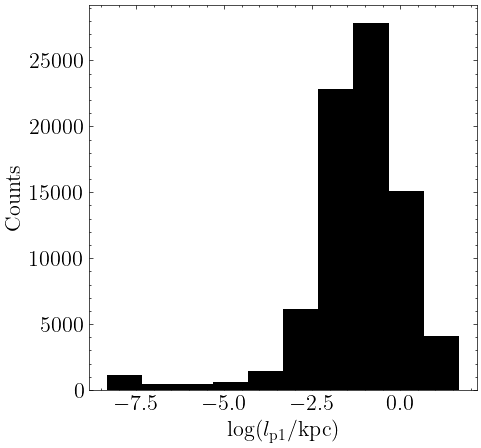

In [104]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [105]:
get_quantiles(np.log10(l_p1))

-1.12 -1.03 1.13


In [106]:
np.median(np.log10(l_p1))-np.percentile(np.log10(l_p1), 100*(1-cdf_1sig))

1.0258280913634388

In [107]:
np.percentile(np.log10(l_p1), 100*cdf_3sig)

1.4229709709376401

Text(0, 0.5, 'Counts')

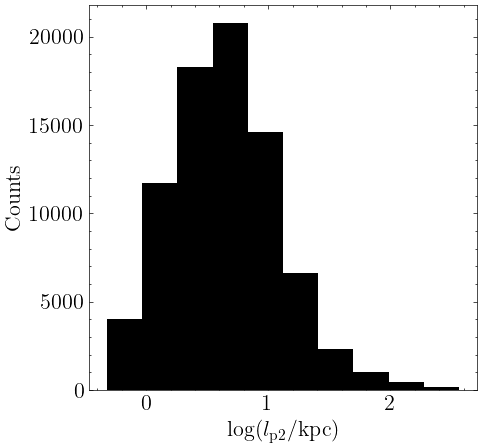

In [108]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [109]:
get_quantiles(np.log10(l_p2))

0.62 -0.43 0.45


In [112]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(-0.23954317486288274, 2.3356196115103875)

In [111]:
np.log10(0.03*(10**-4.3/10**-3)**-1), np.log10(40*(10**-4.3/10**-3)**-0.5)

(-0.22287874528033777, 2.2520599913279624)

In [37]:
logN_species_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples['log_hdens'], flat_samples['log_metals'], 
                                                 species_logN_interp, {'C':flat_samples['C_O'], 'N':flat_samples['N_O']})

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

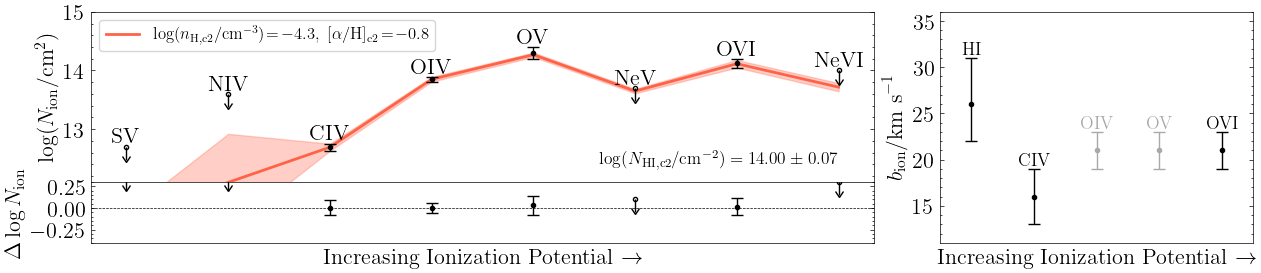

In [41]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=2, alpha=1)

    
plot_column_densities_obs(logN_dict, fig, axd['upper left'], dy=.15)

axd['upper left'].set_ylim(12.1,15.0)

axd['upper left'].text(len(logN_dict)-1, 12.4, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.00 \pm 0.07$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='tomato', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H,c2}/\mathrm{cm}^{-3}) \!=\! -4.3, \ \mathrm{[\alpha/H]_{c2}} \!=\! -0.8$'))

axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12)

plt.subplots_adjust(wspace=0.12, hspace=0)   

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], label_ions=False, dy=.1)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], label_ions=False, dy=.1)

axd['lower left'].set_ylim(-.4,.3)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_linewidth_obs(b_dict, fig, axd['right'], fs=13, gray_out = ['OIV', 'OV'])
axd['right'].set_xlim(-0.5,len(b_dict)-1+.5)
axd['right'].set_ylim(11,36)

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1_op.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=150)